In [1]:
import phoebe
from phoebe import u, c

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

# OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
# CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/irafObjectConcatResults.csv"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/normalizedTimeseries.csv"
GAIA_EPOCH_PHOTOMETRY_CSV = f"{OBJ_DATA_DIR}/Gaia Epoch Photometry - Indiv/EPOCH_PHOTOMETRY-Gaia DR3 1982536257931470464.csv"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

## Iturbide observation data

In [2]:
iturbideObservations = pd.read_csv(CONCAT_OBSERVATIONS_CSV)
iturbideObservations['time'] = pd.to_datetime(iturbideObservations['time']).dt.tz_localize('America/Monterrey')
iturbideObservations

,time,mag,err,raw_flux,ferr,detrend_flux,norm_flux,obsv_date,julianDate
0,2022-10-21 22:54:21.841000-05:00,18.014,0.014,37382.02,483.030554,3264.86,1.109233,2022-10-21,2.459874e+06
1,2022-10-21 22:55:22.219000-05:00,18.044,0.012,36357.11,390.383005,2239.95,1.074942,2022-10-21,2.459874e+06
2,2022-10-21 22:56:22.714000-05:00,18.019,0.013,37214.78,449.139519,3097.62,1.103637,2022-10-21,2.459874e+06
3,2022-10-21 22:57:23.081000-05:00,18.006,0.010,37644.18,346.585443,3527.02,1.118004,2022-10-21,2.459874e+06
4,2022-10-21 22:58:23.606000-05:00,18.035,0.009,36665.20,313.977292,2548.04,1.085250,2022-10-21,2.459874e+06
...,...,...,...,...,...,...,...,...,...
1172,2022-12-10 20:52:39.875000-06:00,18.277,0.015,29324.09,401.032585,-5558.93,0.814015,2022-12-10,2.459924e+06
1173,2022-12-10 20:53:40.007000-06:00,18.267,0.018,29610.24,499.600260,-5272.78,0.823588,2022-12-10,2.459924e+06
1174,2022-12-10 20:54:40.156000-06:00,18.312,0.023,28412.02,610.803870,-6471.00,0.783500,2022-12-10,2.459924e+06
1175,2022-12-10 20:55:40.318000-06:00,18.343,0.017,27607.31,440.367605,-7275.71,0.756576,2022-12-10,2.459924e+06


## Gaia epoch photometry

In [3]:
gaiaObservations = pd.read_csv(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = gaiaObservations[(gaiaObservations['rejected_by_photometry'] == False) & (gaiaObservations['rejected_by_variability'] == False)]

# TODO: correct jdTime here
	# Gaia is barycentric, need to figure out what kind of conversion I'd need to do here to match time used in Iturbide data
gaiaObservations['jdTime'] = gaiaObservations['time'] + 2_455_197.5
gaiaObservations

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,jdTime
0,1982536257931470464,15914106402149388,G,1684.645069,16.809998,3555.883734,13.240487,268.561400,False,False,1,375316653866487564,2.456882e+06
1,1982536257931470464,15923847240881531,G,1684.821236,16.808627,3560.378122,11.872833,299.876040,False,False,1,375316653866487564,2.456882e+06
2,1982536257931470464,15927939542726427,G,1684.895246,16.925122,3198.144064,14.858678,215.237460,False,False,1,375316653866487564,2.456882e+06
3,1982536257931470464,15937680367558820,G,1685.071412,16.899170,3275.507705,64.642659,50.670994,False,False,4097,375316653866487564,2.456883e+06
4,1982536257931470464,15941772663767622,G,1685.145395,16.775474,3670.768815,13.205851,277.965330,False,False,4194305,375316653866487564,2.456883e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1982536257931470464,68564649765818840,RP,2636.797157,16.107843,2857.728742,34.570173,82.664580,False,False,0,375316653866487564,2.457834e+06
209,1982536257931470464,68574390600082284,RP,2636.973312,16.210664,2599.517311,29.385957,88.461210,False,False,0,375316653866487564,2.457834e+06
210,1982536257931470464,68578482921453413,RP,2637.047319,16.354475,2277.026942,38.569154,59.037514,False,False,0,375316653866487564,2.457835e+06
211,1982536257931470464,71504440274863554,RP,2689.962995,16.131512,2796.104174,30.633779,91.275200,False,False,0,375316653866487564,2.457887e+06


In [4]:
gaia_g  = gaiaObservations[gaiaObservations['band'] == 'G']
gaia_bp = gaiaObservations[gaiaObservations['band'] == 'BP']
gaia_rp = gaiaObservations[gaiaObservations['band'] == 'RP']

gaia_g, gaia_bp, gaia_rp

(              source_id         transit_id band         time        mag  \
 0   1982536257931470464  15914106402149388    G  1684.645069  16.809998   
 1   1982536257931470464  15923847240881531    G  1684.821236  16.808627   
 2   1982536257931470464  15927939542726427    G  1684.895246  16.925122   
 3   1982536257931470464  15937680367558820    G  1685.071412  16.899170   
 4   1982536257931470464  15941772663767622    G  1685.145395  16.775474   
 ..                  ...                ...  ...          ...        ...   
 66  1982536257931470464  68564649765818840    G  2636.796754  16.720235   
 67  1982536257931470464  68574390600082284    G  2636.972911  16.791708   
 68  1982536257931470464  68578482921453413    G  2637.046918  17.010545   
 69  1982536257931470464  71504440274863554    G  2689.962565  16.739720   
 70  1982536257931470464  71508532541583929    G  2690.036603  16.936466   
 
            flux  flux_error  flux_over_error  rejected_by_photometry  \
 0   3555.883

## PHOEBE bundle set-up

In [5]:
b = phoebe.default_contact_binary()

In [11]:
b.add_compute(
    compute='fast_compute',
    
    # speed up compute for the sake of the demo; DON'T PUBLISH WITH THESE
    irrad_method='none',
    # rv_method='dynamical', # no meshing; compute rvs from first principles
    distortion_method='sphere',
    atm='blackbody',
    overwrite=True
)

<ParameterSet: 76 parameters | datasets: lc_iturbide_raw, lc_gaia_g_raw, lc_gaia_rp_raw, _default, lc_gaia_bp, lc_gaia_bp_raw, lc_gaia_g, lc_iturbide, lc_gaia_rp>

In [ ]:
computePhases = phoebe.linspace(0, 1, 16)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True)
print(b['mesh01'])

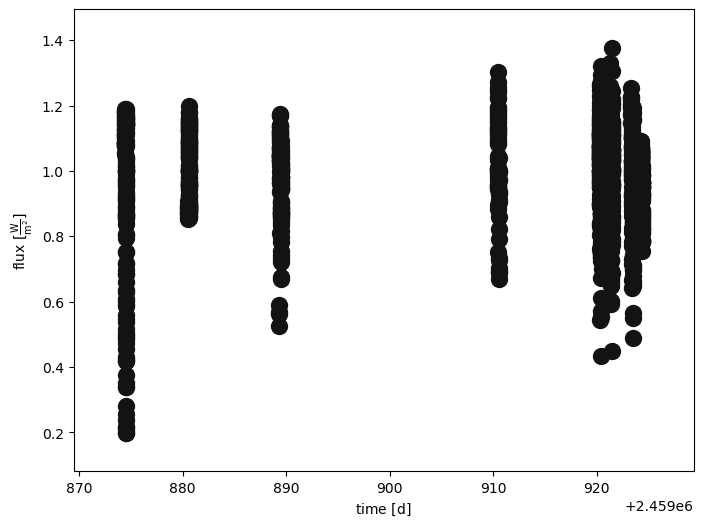

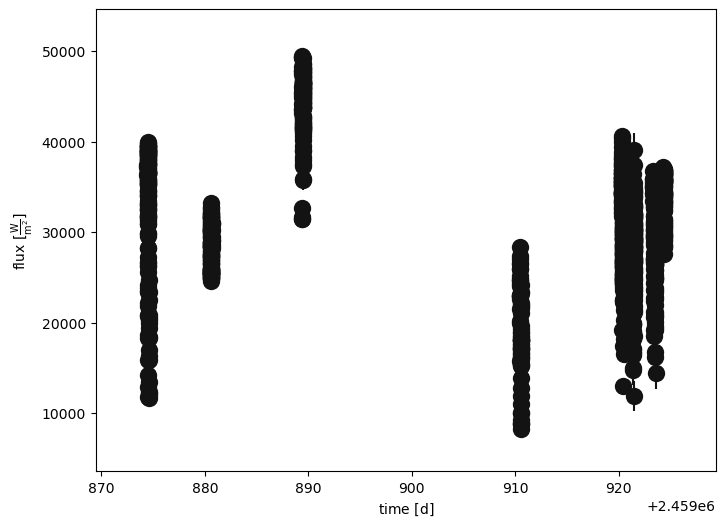

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [12]:
b.add_dataset('lc', dataset='lc_iturbide', overwrite=True,
              times=iturbideObservations['julianDate'].to_numpy()*u.day, 
              fluxes=iturbideObservations['norm_flux'].to_numpy())
b.add_dataset('lc', dataset='lc_iturbide_raw', overwrite=True,
              times=iturbideObservations['julianDate'].to_numpy()*u.day, 
              fluxes=iturbideObservations['raw_flux'].to_numpy(), sigmas=iturbideObservations['ferr'].to_numpy())
b.plot(dataset='lc_iturbide', show=True)
b.plot(dataset='lc_iturbide_raw', show=True)

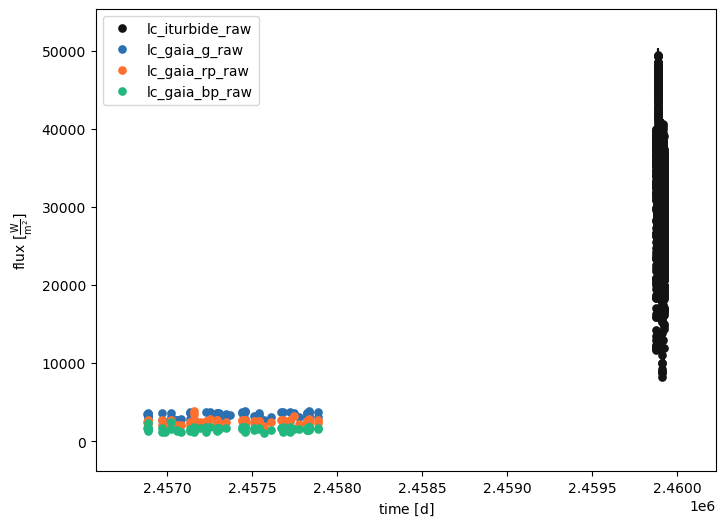

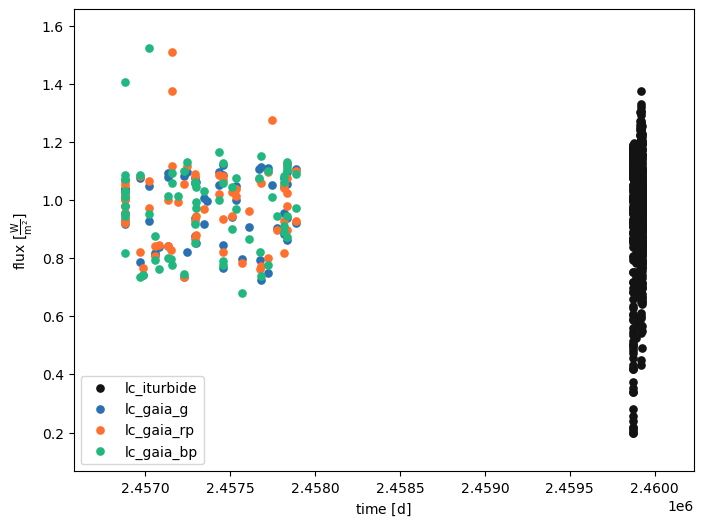

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [13]:
gaia_g_fluxes  = gaia_g['flux'].to_numpy()
gaia_rp_fluxes = gaia_rp['flux'].to_numpy()
gaia_bp_fluxes = gaia_bp['flux'].to_numpy()
b.add_dataset('lc', 
              times=gaia_g['jdTime'].to_numpy()*u.day, fluxes=gaia_g_fluxes/np.median(gaia_g_fluxes), 
              passband='Gaia:G', dataset='lc_gaia_g', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jdTime'].to_numpy()*u.day, fluxes=gaia_rp_fluxes/np.median(gaia_rp_fluxes), 
              passband='Gaia:RP', dataset='lc_gaia_rp', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jdTime'].to_numpy()*u.day, fluxes=gaia_bp_fluxes/np.median(gaia_bp_fluxes), 
              passband='Gaia:BP', dataset='lc_gaia_bp', overwrite=True)

b.add_dataset('lc', 
              times=gaia_g['jdTime'].to_numpy()*u.day, fluxes=gaia_g_fluxes, sigmas=gaia_g['flux_error'].to_numpy(),
              passband='Gaia:G', dataset='lc_gaia_g_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jdTime'].to_numpy()*u.day, fluxes=gaia_rp_fluxes, sigmas=gaia_rp['flux_error'].to_numpy(),
              passband='Gaia:RP', dataset='lc_gaia_rp_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jdTime'].to_numpy()*u.day, fluxes=gaia_bp_fluxes, sigmas=gaia_bp['flux_error'].to_numpy(),
              passband='Gaia:BP', dataset='lc_gaia_bp_raw', overwrite=True)
# b.plot(kind='lc', dataset=['lc_gaia_g', 'lc_gaia_bp', 'lc_gaia_rp'], show=True, legend=True, marker='.')
# b.plot(kind='lc', dataset='lc_gaia_g', show=True, legend=True)
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' in d], show=True, legend=True, marker='.')
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')

In [14]:
# disabled by default, not sure if gaia data will be useful here
b.disable_dataset('lc_gaia_g')
b.disable_dataset('lc_gaia_rp')
b.disable_dataset('lc_gaia_bp')

# also disable raw datasets by default, only want to work with normalized data for now
[b.disable_dataset(d) for d in b.datasets if 'raw' in d and d != 'mesh01']

[<ParameterSet: 20 parameters | components: binary, primary, secondary>,
 <ParameterSet: 20 parameters | components: binary, primary, secondary>,
 <ParameterSet: 20 parameters | components: binary, primary, secondary>,
 <ParameterSet: 20 parameters | components: binary, primary, secondary>]

In [15]:
b.save("./bundle-saves/iturbide_gaia-data")

'./bundle-saves/iturbide_gaia-data'